In [54]:
import json
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from itertools import zip_longest


In [25]:
folder_path = r"C:\Users\fleur\OneDrive\Documents\Fleur\TU Delft\TIL\Advanced Data Science for\force_cases_batch_1"

all_dfs = [] 

for file in os.listdir(folder_path):
    if file.endswith(".json"):
        file_path = os.path.join(folder_path, file)
        with open(file_path, encoding="utf-8") as f:
            
            data = json.load(f)
            

        df = pd.json_normalize(
            data,
            record_path="raw_measurements",
            meta=["version","type","start_time","end_time","sampling_rate","weight_filter","zero_offset","expected_weight","robot_type","eoat_params"],
            errors="ignore"
        )
        
        df["source_file"] = file  
        
        all_dfs.append(df)

big_df = pd.concat(all_dfs, ignore_index=True)



print(big_df.shape)
print(big_df.columns)
print(big_df.head())

(1710410, 20)
Index(['timestamp', 'value', 'force_vector', 'robot_tcp.timestamp',
       'robot_tcp.flange', 'robot_tcp.tcp_offset', 'robot_tcp.velocity_linear',
       'robot_tcp.velocity_angular', 'robot_tcp.joint_angles', 'version',
       'type', 'start_time', 'end_time', 'sampling_rate', 'weight_filter',
       'zero_offset', 'expected_weight', 'robot_type', 'eoat_params',
       'source_file'],
      dtype='object')
      timestamp  value          force_vector  robot_tcp.timestamp  \
0  1.749981e+09  0.035  [0.438, 0.822, 14.0]         1.749981e+09   
1  1.749981e+09  0.032  [0.397, 0.804, 14.0]         1.749981e+09   
2  1.749981e+09  0.029  [0.351, 0.786, 14.0]         1.749981e+09   
3  1.749981e+09  0.026  [0.306, 0.771, 14.0]         1.749981e+09   
4  1.749981e+09  0.023  [0.258, 0.762, 14.0]         1.749981e+09   

                                    robot_tcp.flange  \
0  [[-0.6839283108711243, -0.7488531470298767, -0...   
1  [[-0.6836240291595459, -0.7489932775497437, 

In [26]:
df[["Mx","My","Fz"]] = pd.DataFrame(df.pop("force_vector").tolist(), index=df.index)

flange = pd.DataFrame(df.pop("robot_tcp.flange").tolist(), index=df.index)
df[["flange_tx","flange_ty","flange_tz"]] = pd.DataFrame(flange[0].tolist(), index=df.index)
df[["flange_qw","flange_qx","flange_qy","flange_qz"]] = pd.DataFrame(flange[1].tolist(), index=df.index)

tcp_off = pd.DataFrame(df.pop("robot_tcp.tcp_offset").tolist(), index=df.index)
df[["tcp_tx","tcp_ty","tcp_tz"]] = pd.DataFrame(tcp_off[0].tolist(), index=df.index)
df[["tcp_qw","tcp_qx","tcp_qy","tcp_qz"]] = pd.DataFrame(tcp_off[1].tolist(), index=df.index)

df[["tcp_vx","tcp_vy","tcp_vz"]] = pd.DataFrame(df.pop("robot_tcp.velocity_linear").tolist(), index=df.index)

df[["tcp_wx","tcp_wy","tcp_wz"]] = pd.DataFrame(df.pop("robot_tcp.velocity_angular").tolist(), index=df.index)

df[["joint_base","joint_shoulder","joint_elbow","joint_wrist_1","joint_wrist_2","joint_wrist_3"]] = (
    pd.DataFrame(df.pop("robot_tcp.joint_angles").tolist(), index=df.index)
)


t_num = pd.to_numeric(df["timestamp"], errors="coerce")
t_rel_ms_num = (t_num - t_num.iloc[0]) * 1000
t_dt = pd.to_datetime(df["timestamp"], errors="coerce")
t_rel_ms_dt = (t_dt - t_dt.iloc[0]) / pd.to_timedelta(1, "ms")
time_ms = t_rel_ms_num.fillna(t_rel_ms_dt)


rt_num = pd.to_numeric(df["robot_tcp.timestamp"], errors="coerce")
rt_rel_ms = (rt_num - rt_num.iloc[0]) * 1000

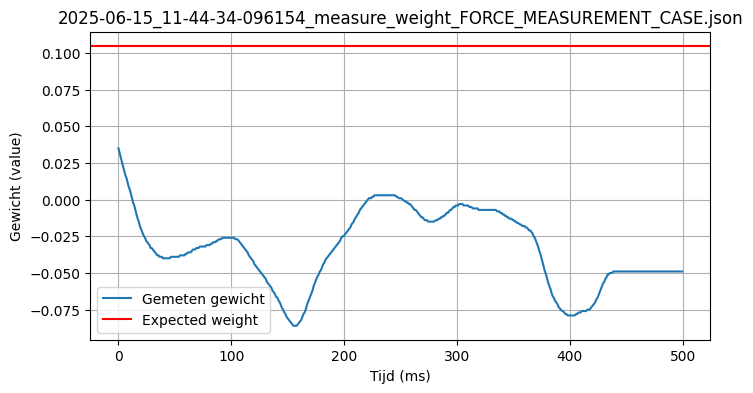

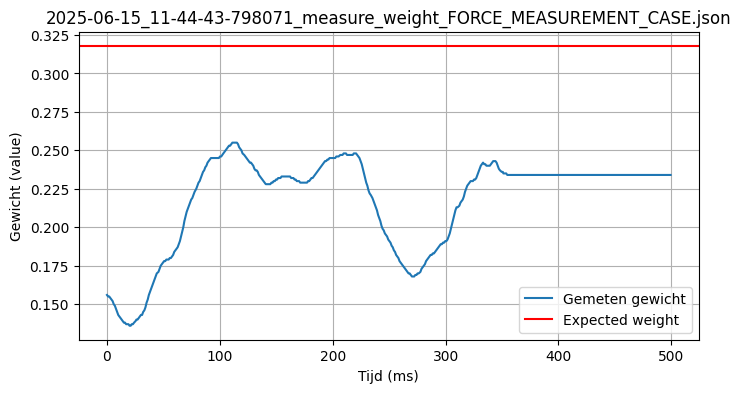

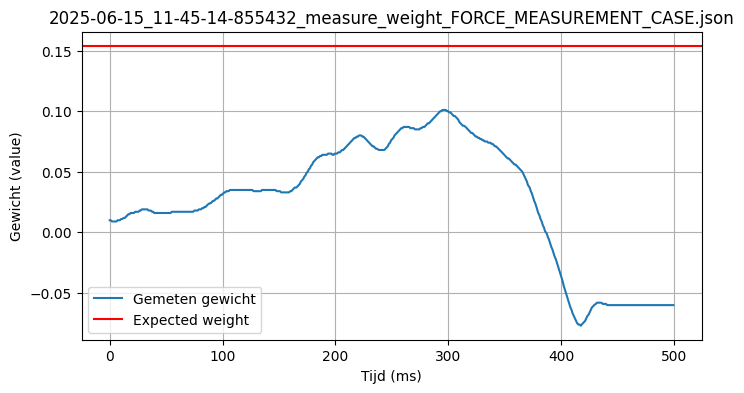

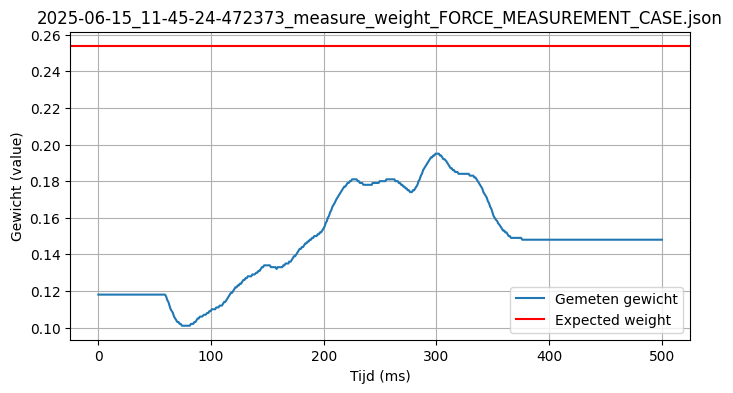

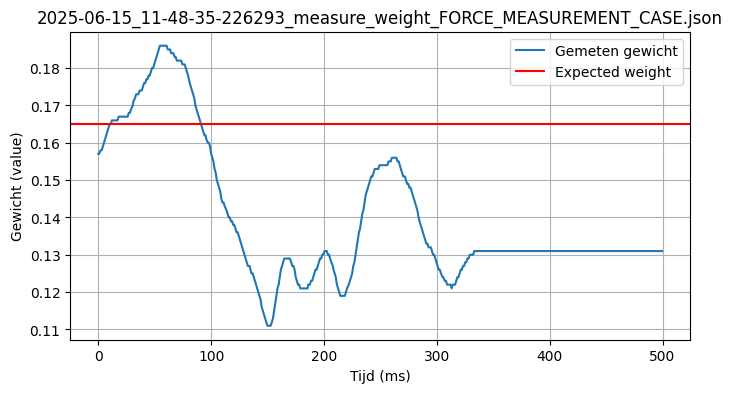

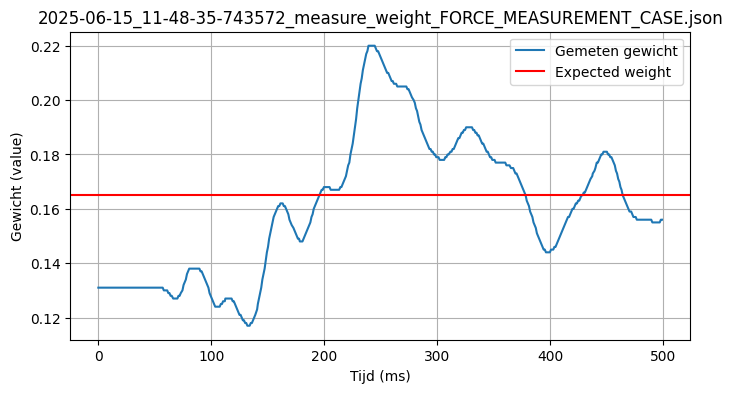

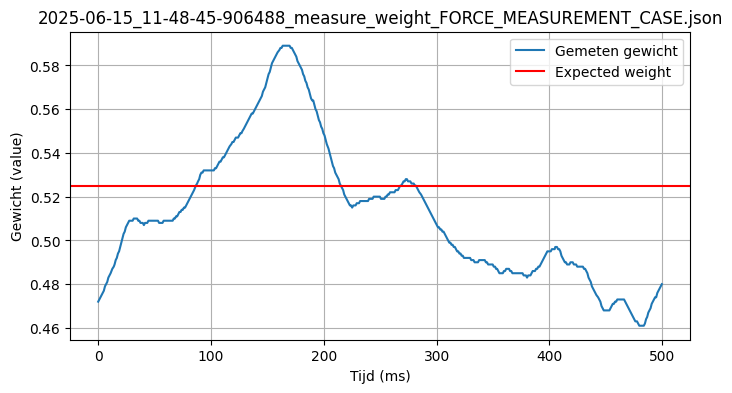

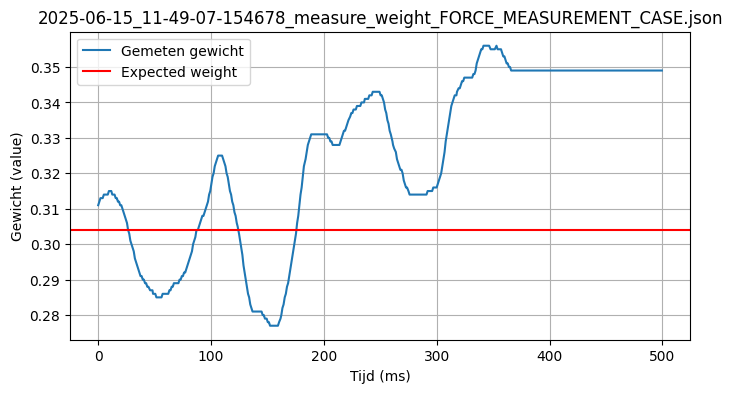

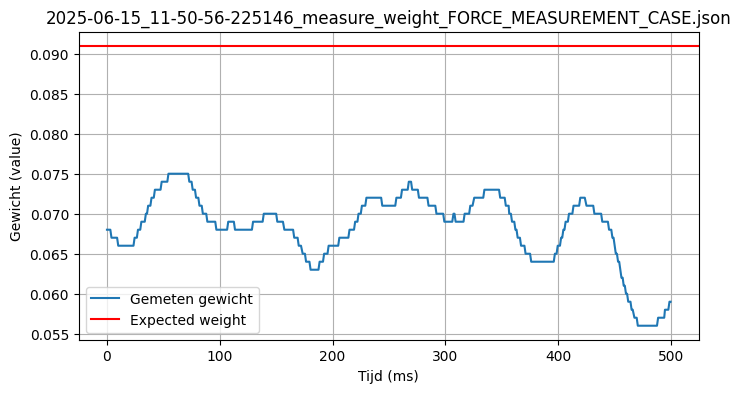

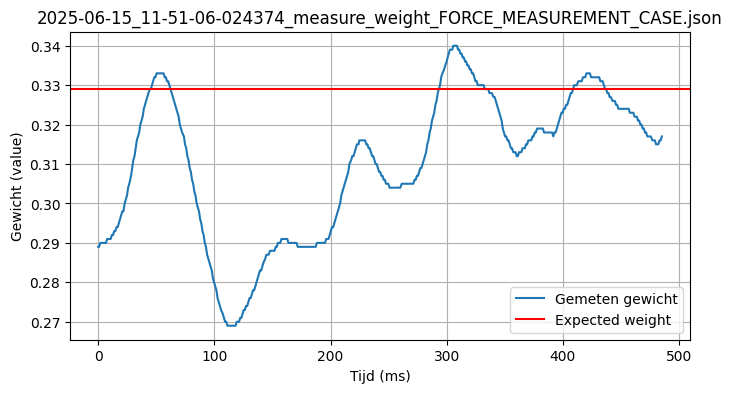

In [32]:
unique_files = big_df["source_file"].unique()

for file in unique_files[:10]:
    subset = big_df[big_df["source_file"] == file]

    t = (pd.to_numeric(subset["timestamp"], errors="coerce") - 
         pd.to_numeric(subset["timestamp"], errors="coerce").iloc[0]) * 1000  # ms
    y = subset["value"]

    plt.figure(figsize=(8,4))
    plt.plot(t, y, label="Gemeten gewicht")
    plt.axhline(subset["expected_weight"].iloc[0], color="red", label="Expected weight")
    plt.title(f"{file}")
    plt.xlabel("Tijd (ms)")
    plt.ylabel("Gewicht (value)")
    plt.legend()
    plt.grid(True)
    plt.show()

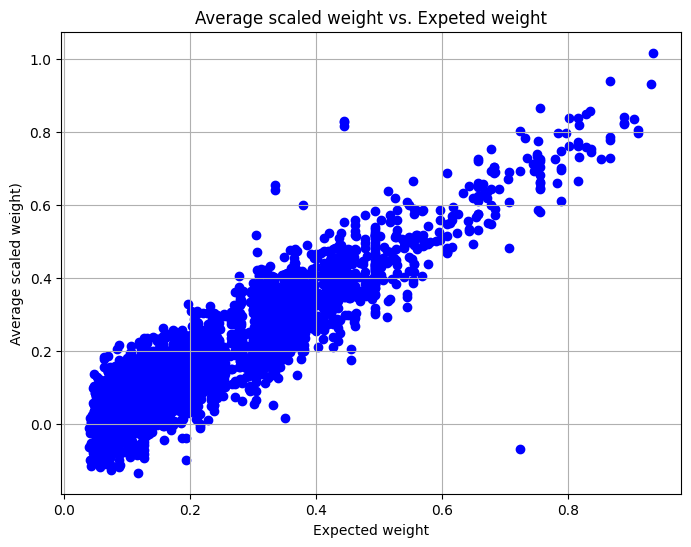

In [45]:
avg_results = []

for file, subset in big_df.groupby("source_file"):
    mean_value = subset["value"].mean()
    expected_weight = subset["expected_weight"].iloc[0]

    avg_results.append({"file": file, 
                        "mean_value": mean_value, 
                        "expected_weight": expected_weight})

avg_df = pd.DataFrame(avg_results)

plt.figure(figsize=(8,6))
plt.scatter(avg_df["expected_weight"], avg_df["mean_value"], color="b", )


plt.xlabel("Expected weight")
plt.ylabel("Average scaled weight)")
plt.title("Average scaled weight vs. Expeted weight")
plt.grid(True)
plt.show()

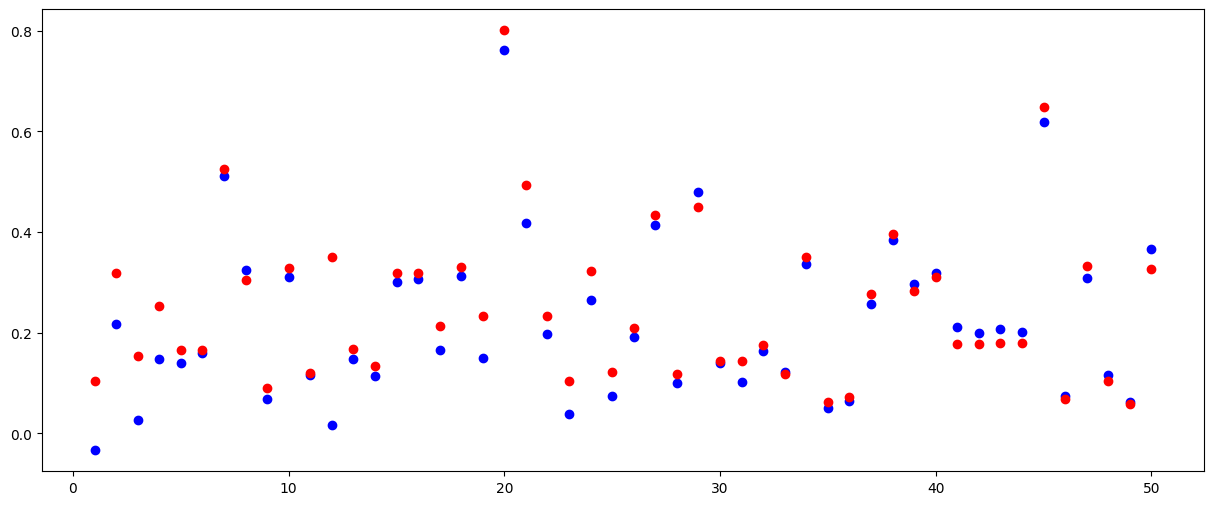

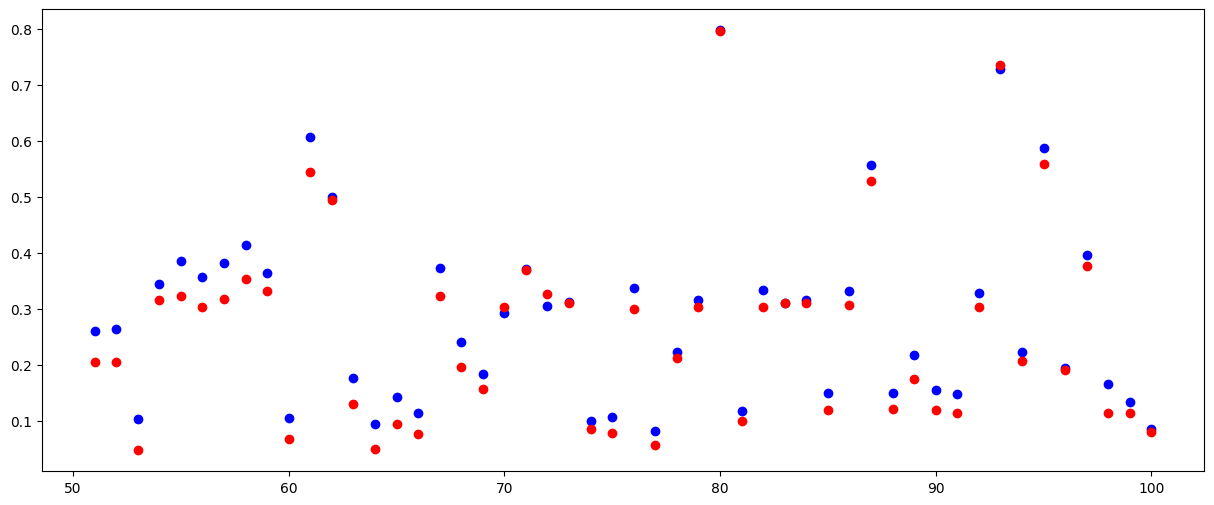

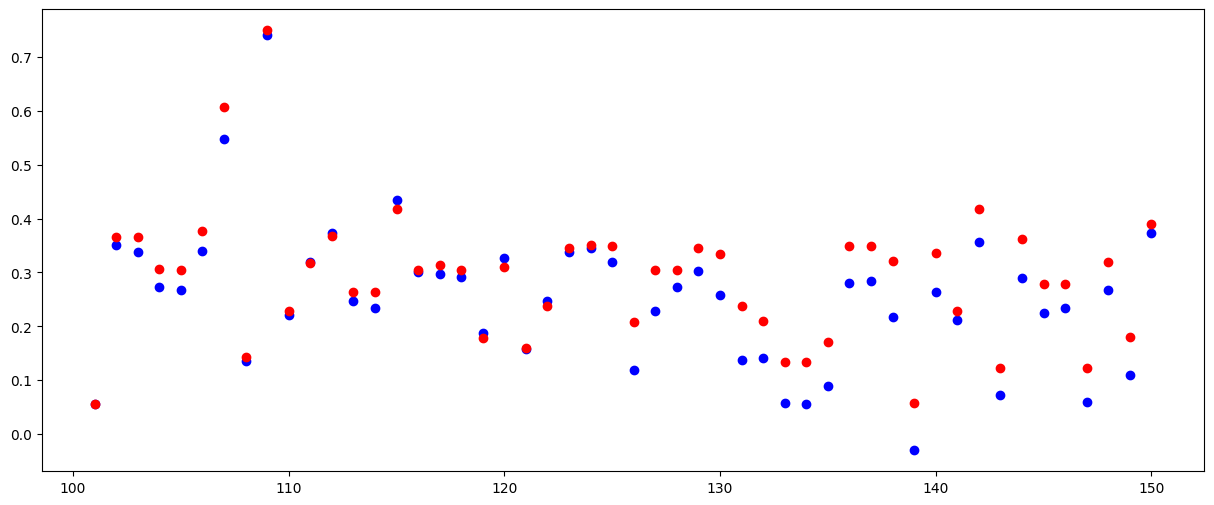

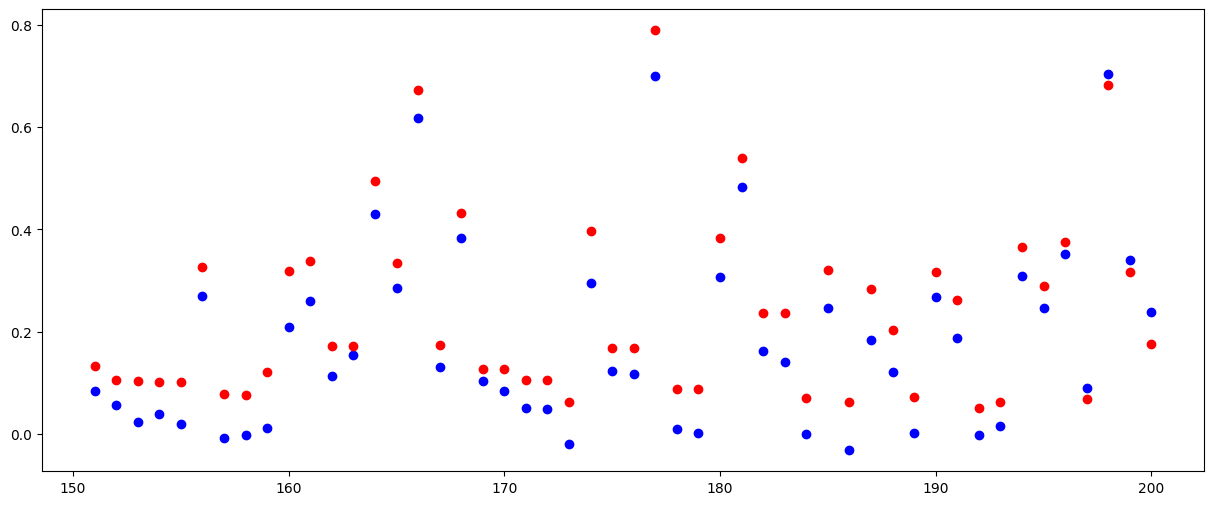

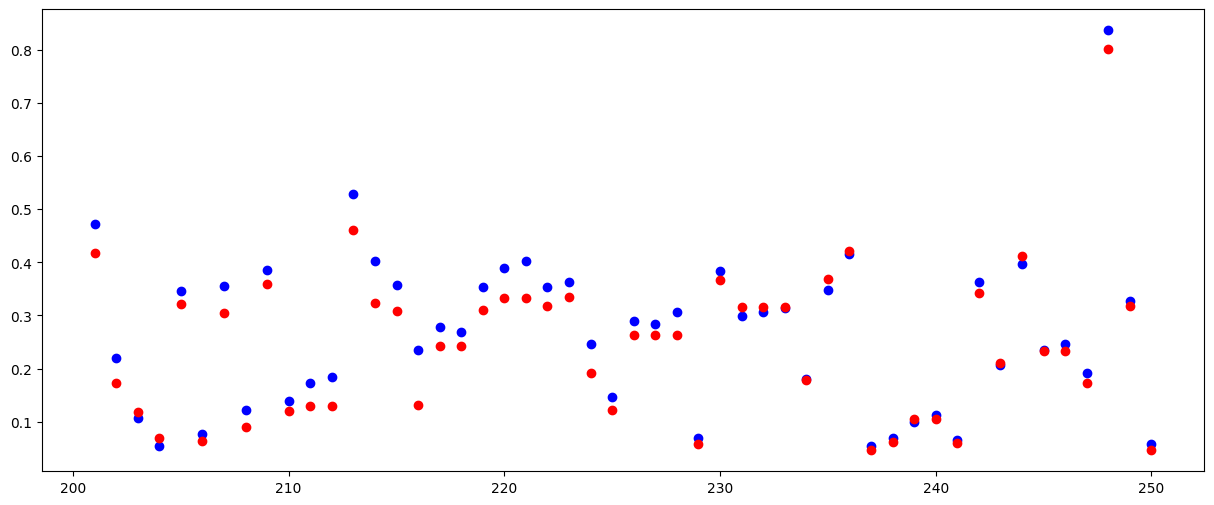

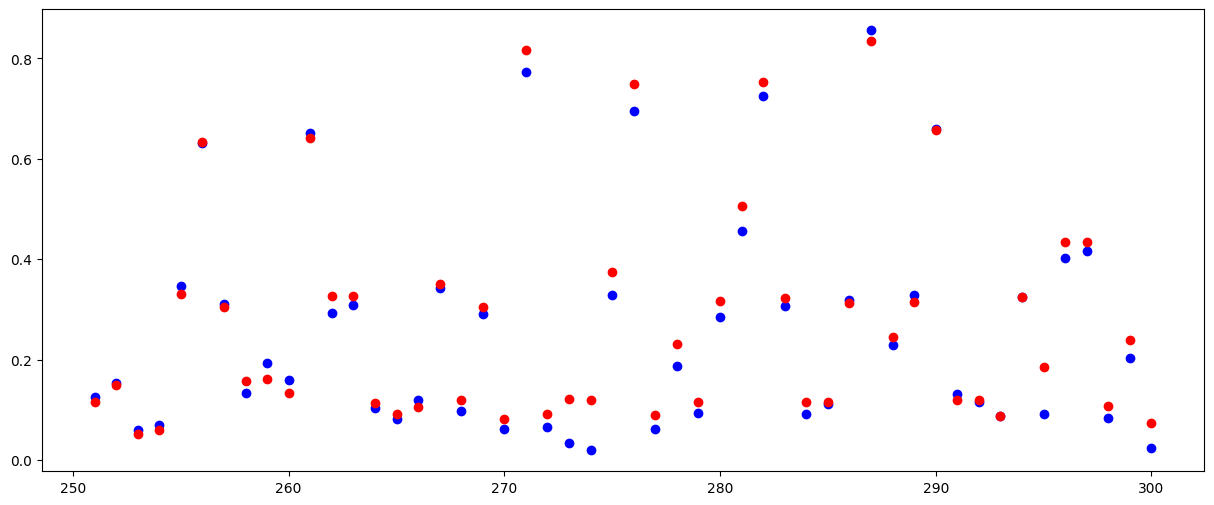

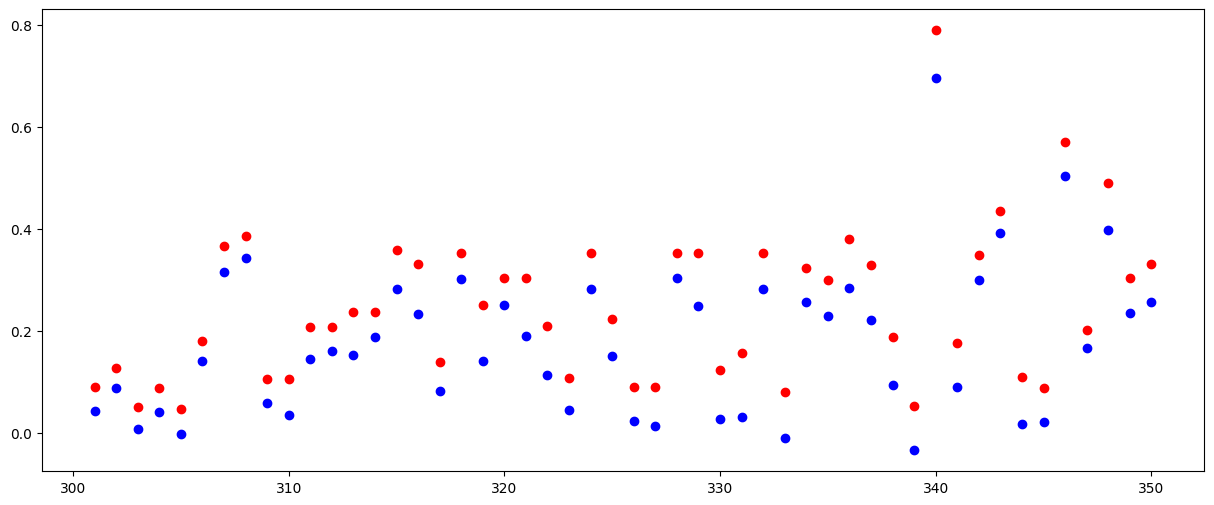

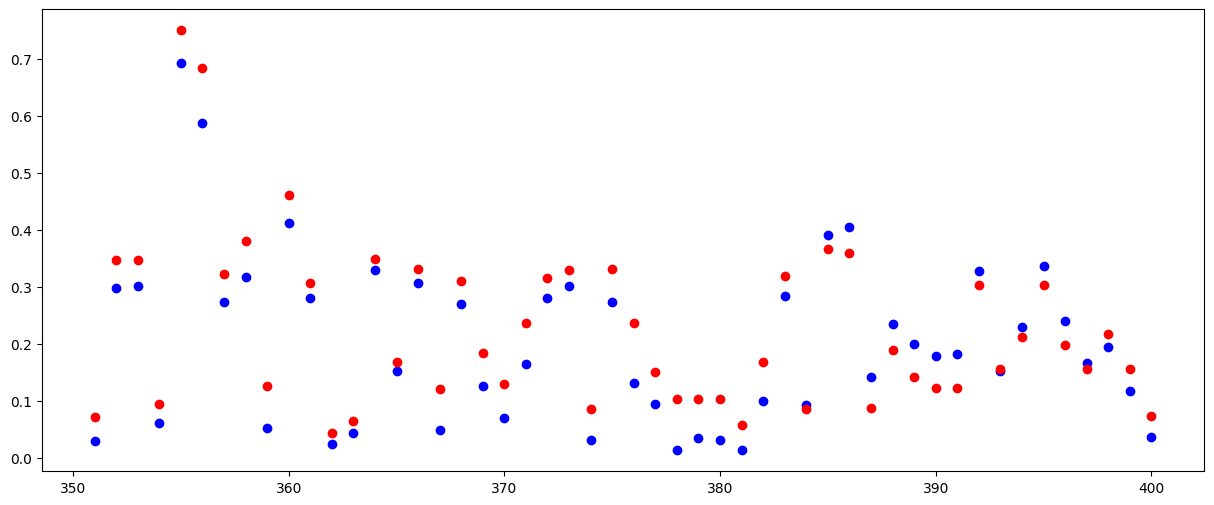

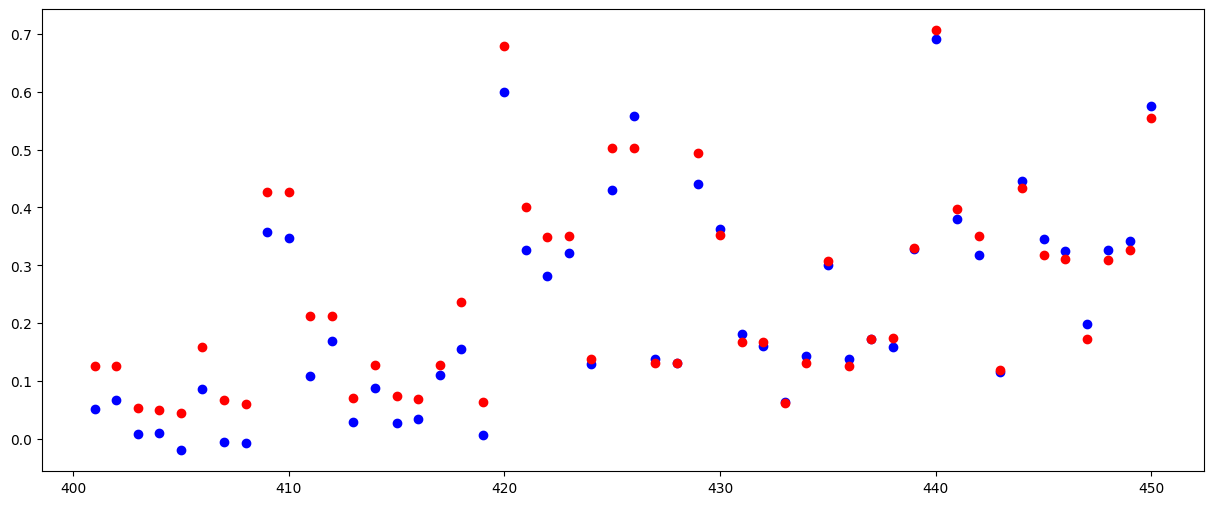

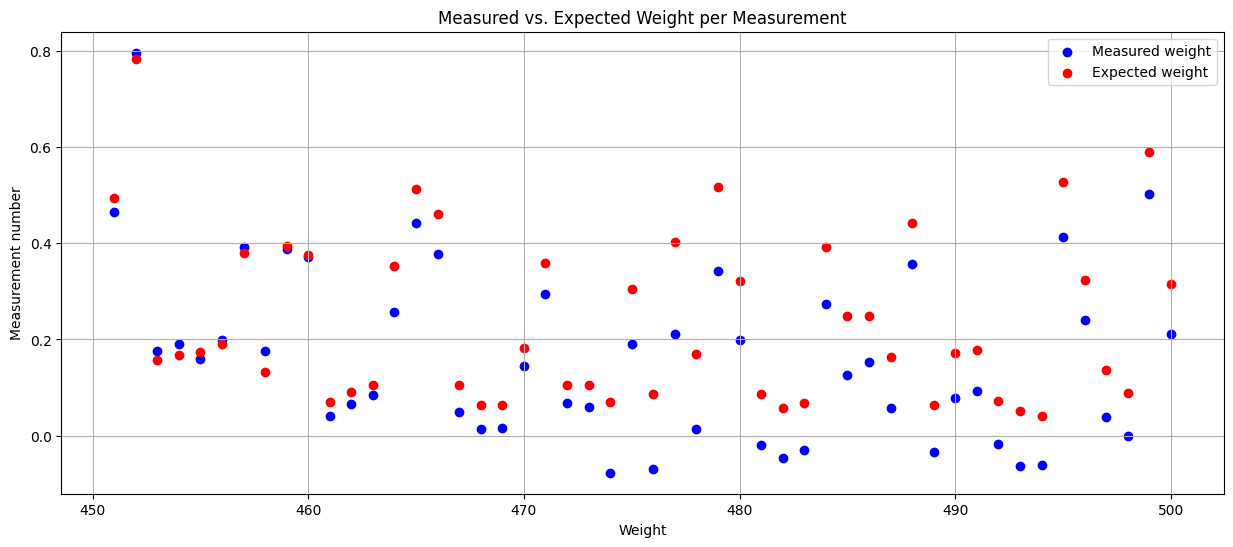

In [59]:
chunk_size = 50
max_chunks = 10 
# num_chunks = math.ceil(len(avg_df) / chunk_size)

for i in range(max_chunks):
    start = i * chunk_size
    end = start + chunk_size
    chunk = avg_df.iloc[start:end]

    plt.figure(figsize=(15, 6))

    plt.scatter(chunk["measurement_id"], chunk["mean_value"], color="blue", label="Measured weight")

    plt.scatter(chunk["measurement_id"], chunk["expected_weight"], color="red", label="Expected weight")

plt.xlabel("Weight")
plt.ylabel("Measurement number")
plt.title("Measured vs. Expected Weight per Measurement")
plt.legend()
plt.grid(True)
plt.show()